In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
labels_per_class = 3
X_labeled, Y_labeled, Y_masked = mask_labels(X_train, Y_train, labels_per_class = labels_per_class)

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [17]:

last_layer_dims = 512
lr_alpha = 0.1
dropout_rate = 0.1

In [18]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(dropout_rate))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=last_layer_dims, activation="relu"))
encoder.add(tf.keras.layers.Dropout(dropout_rate))

In [19]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(last_layer_dims)))
classifier.add(tf.keras.layers.Dense(units=last_layer_dims, activation="relu"))
classifier.add(tf.keras.layers.Dense(units=last_layer_dims, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [20]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(last_layer_dims)))
embedder.add(tf.keras.layers.Dense(units=last_layer_dims, activation="relu"))
embedder.add(tf.keras.layers.Dense(units=last_layer_dims, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [21]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6423040   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

### Create UMAP object

In [22]:
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability

In [23]:
from tfumap.semisupervised import find_a_b, compute_umap_loss, compute_classifier_loss, batch_data

In [24]:
class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        umap_prop=1.0,  # to what extent do we train UMAP
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        self.umap_prop = umap_prop

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.classifier_optimizer = tf.keras.optimizers.Adam(0.01)
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.create_summary_metrics()

    def create_summary_metrics(self):

        """
        Create keras summary objects for loss
        """
        self.summary_metrics = {}
        self.summary_metrics["train_loss_umap"] = tf.keras.metrics.Mean(
            "train_loss_umap", dtype=tf.float32
        )
        self.summary_metrics["train_loss_classif"] = tf.keras.metrics.Mean(
            "train_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_loss_classif"] = tf.keras.metrics.Mean(
            "valid_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["train_acc_classif"] = tf.keras.metrics.Accuracy(
            "train_acc_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_acc_classif"] = tf.keras.metrics.Accuracy(
            "valid_acc_classif", dtype=tf.float32
        )
    
    #@tf.function
    def write_acc(self, X, y, batch, train=True):
        predictions = self.classify_data(X)

        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"
        
        self.summary_metrics[train_valid + "_acc_classif"].reset_states()
        self.summary_metrics[train_valid + "_acc_classif"].update_state(predictions, y)

        # write loss
        with summary_writer.as_default():
            tf.summary.scalar(
                "acc_classif",
                self.summary_metrics[train_valid + "_acc_classif"].result(),
                step=batch,
            )
            summary_writer.flush()
    
    #@tf.function
    def write_losses(self, batch, classif_loss, umap_loss=None, train=True):
        # add umap loss
        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
            self.summary_metrics[train_valid + "_loss_umap"].reset_states()
            self.summary_metrics[train_valid + "_loss_umap"](umap_loss)
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        # add valid loss
        self.summary_metrics[train_valid + "_loss_classif"].reset_states()
        self.summary_metrics[train_valid + "_loss_classif"](classif_loss)

        # write loss
        with summary_writer.as_default():
            if train:
                tf.summary.scalar(
                    "umap_loss",
                    self.summary_metrics[train_valid + "_loss_umap"].result(),
                    step=batch,
                )
            tf.summary.scalar(
                "classif_loss",
                self.summary_metrics[train_valid + "_loss_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        if self.umap_prop > 0:
            with tf.GradientTape() as tape:

                (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                    batch_to,
                    batch_from,
                    self.embedder,
                    self.encoder,
                    self._a,
                    self._b,
                    self.negative_sample_rate,
                    self.repulsion_strength,
                )

                classifier_loss = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce
                )
                loss = (
                    tf.reduce_sum(classifier_loss)
                    + tf.reduce_sum(umap_loss) * self.umap_prop
                )

            train_vars = (
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables
            )
        else:
            with tf.GradientTape() as tape:
                classifier_loss = loss = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce
                )
            train_vars = (
                self.encoder.trainable_variables + self.classifier.trainable_variables
            )
            attraction_loss = repellant_loss = umap_loss = 0

        # compute gradient for umap
        grad = tape.gradient(loss, train_vars)

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(zip(grad, train_vars))

        return (attraction_loss, repellant_loss, umap_loss, classifier_loss)

    # @tf.function
    def project_epoch(self, X):
        """ Train a batch in tensorflow
        """
        return [self.embedder(self.encoder(batch)) for batch in X]

    def get_dataset_loss(self, dataset):
        return [
            compute_classifier_loss(X, y, self.encoder, self.classifier, self.sparse_ce)
            for X, y in dataset
        ]

    
    def classify_data(self, X):
        """ Classify a set of points X
        """
        X_batch = batch_data(X, batch_size=100)
        predictions = tf.concat([classifier(encoder(i)) for i in tqdm(X_batch, leave=False)], axis=0)
        predictions = tf.nn.softmax(predictions)
        return tf.argmax(predictions, 1)

In [25]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [26]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-4), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [27]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


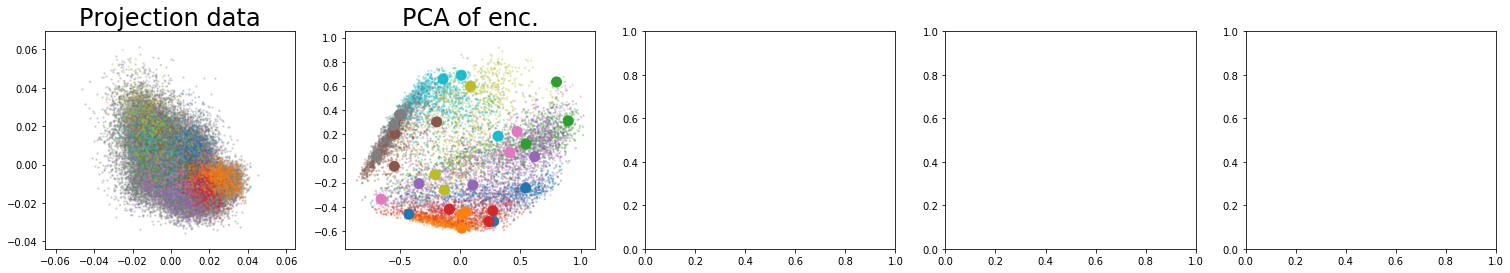

In [28]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [29]:
batch = 0; epoch = 0
N_EPOCHS = 10 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[0 1 2 3 4 5 6 7 8 9]


In [30]:
#z_valid = UMAP(verbose=True).fit_transform(latent_valid.numpy())

batch: 5000


5000


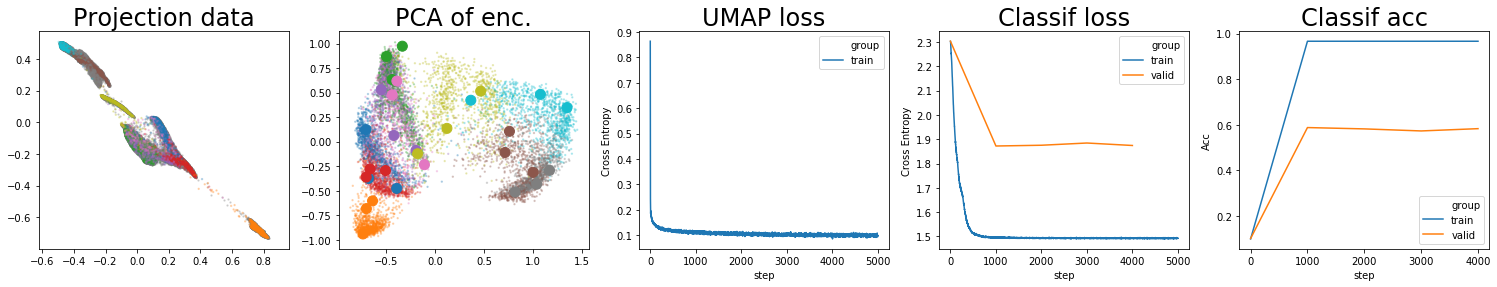

batch: 6000


6000


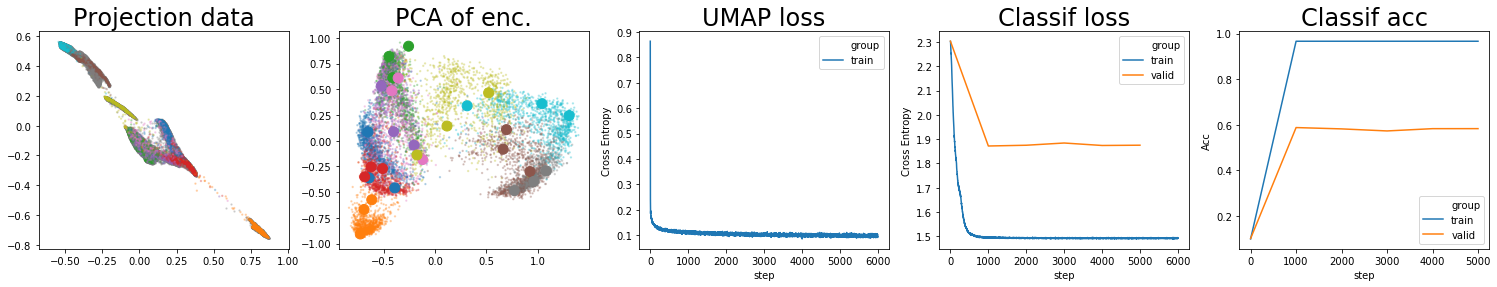

batch: 7000


7000


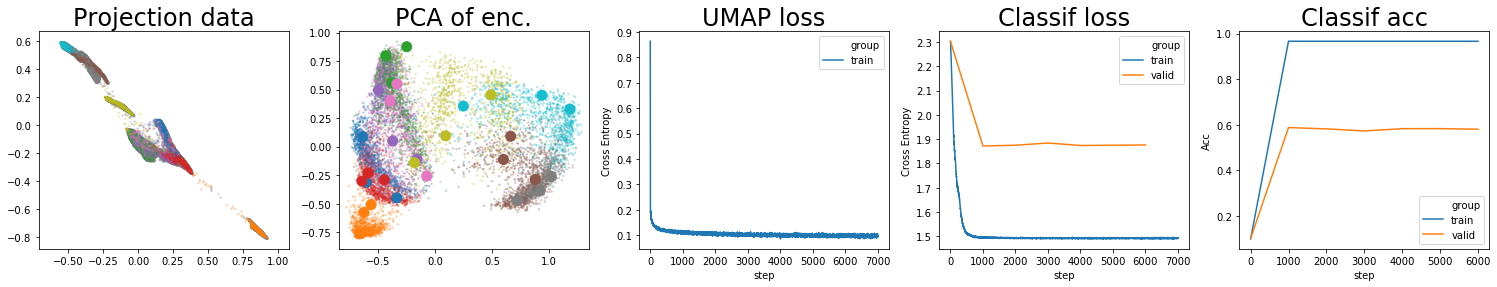

batch: 8000


8000


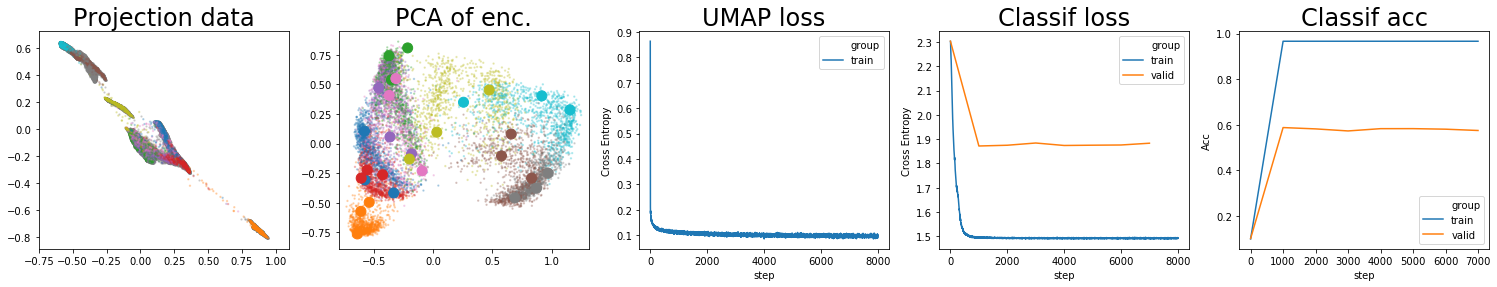

batch: 9000


9000


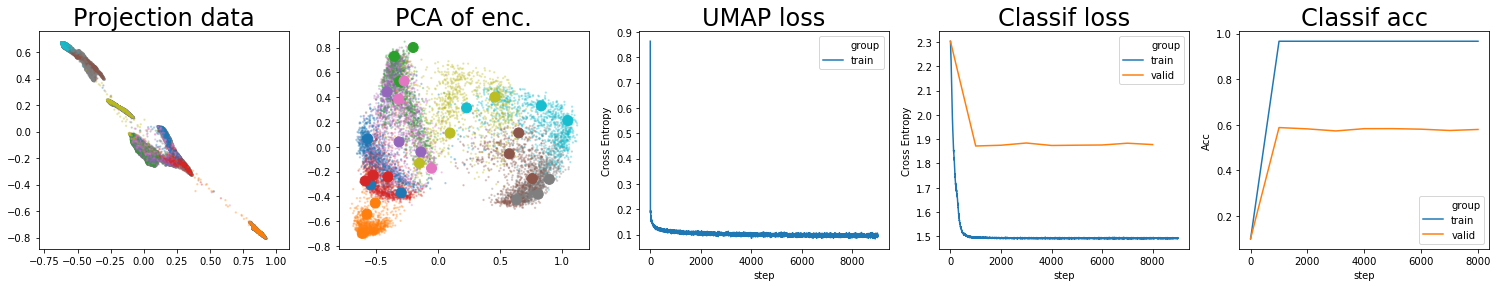

batch: 10000


10000


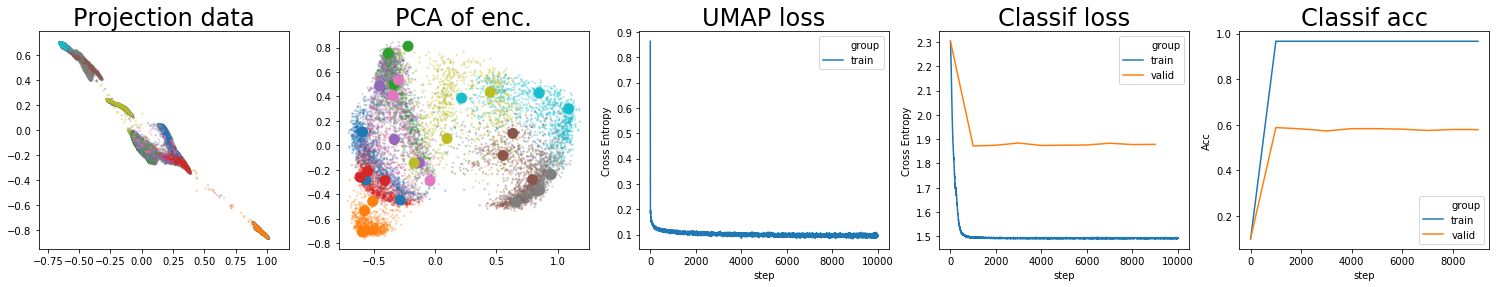

batch: 11000


11000


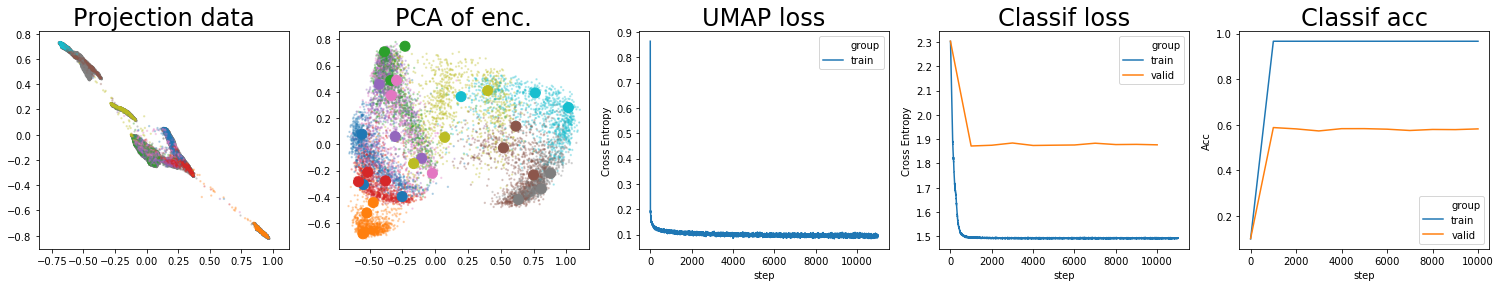

batch: 12000


12000


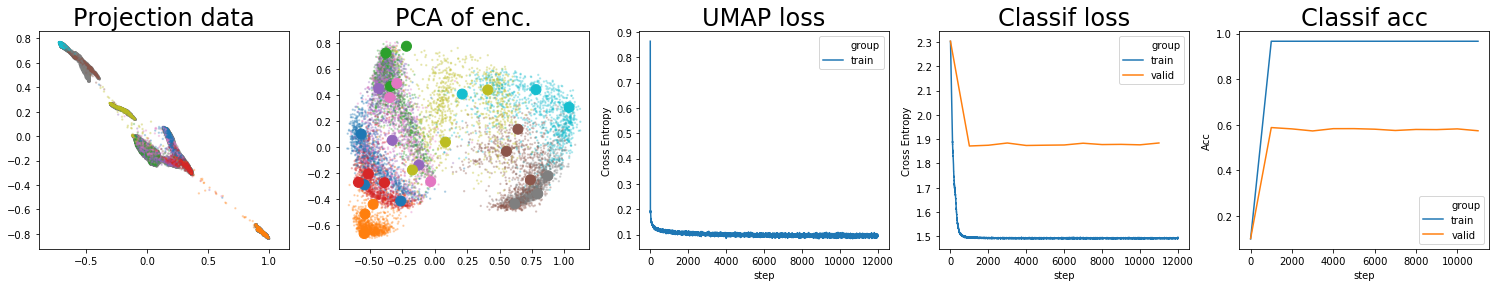

batch: 13000


13000


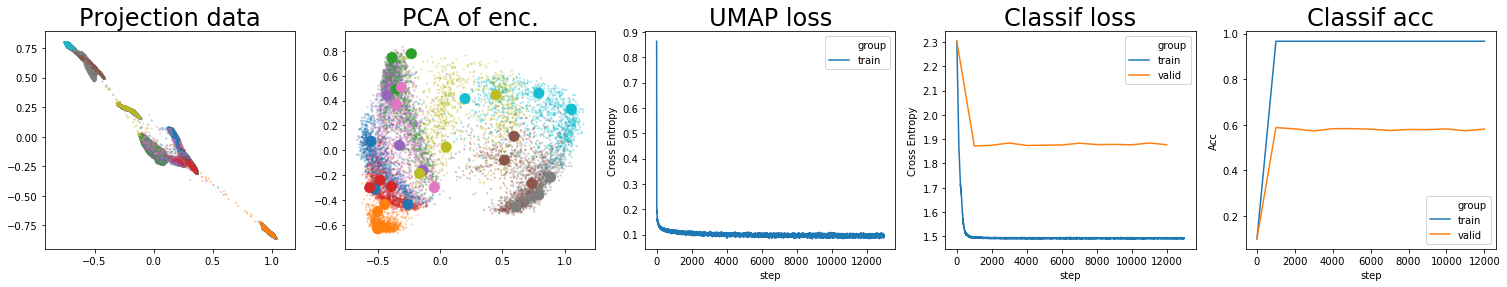

batch: 14000


14000


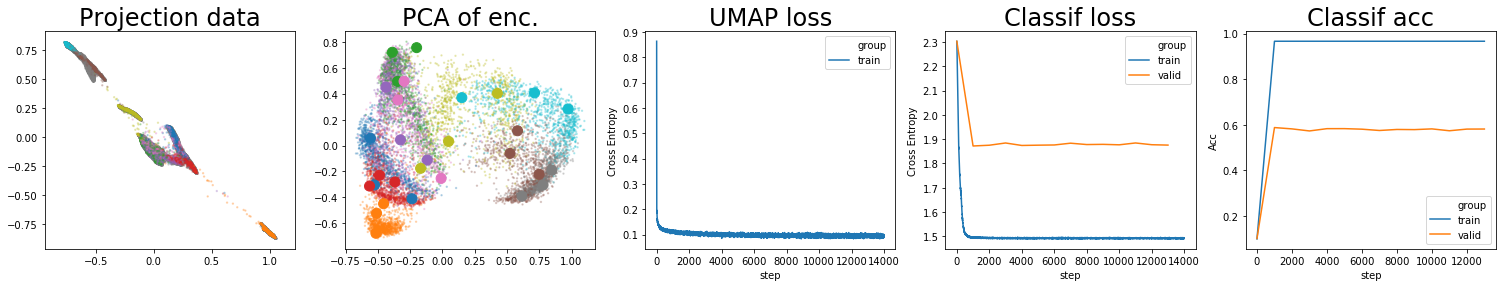

batch: 15000


15000


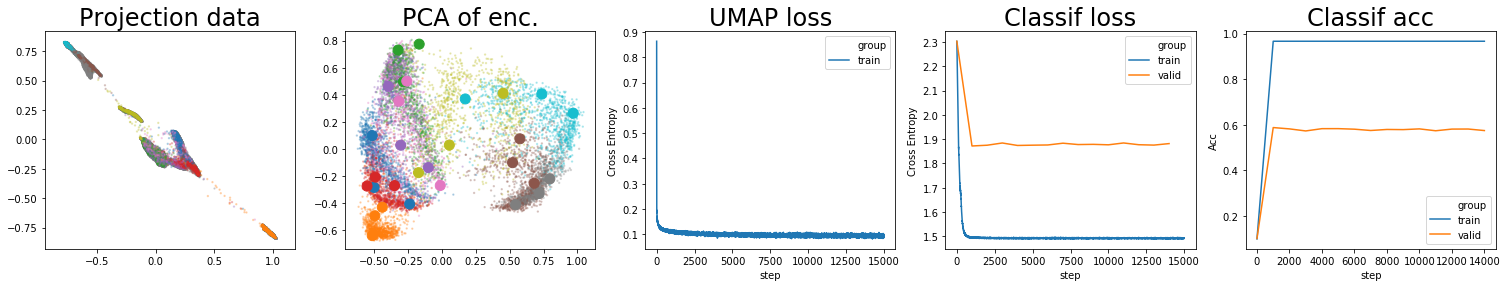

batch: 16000


16000


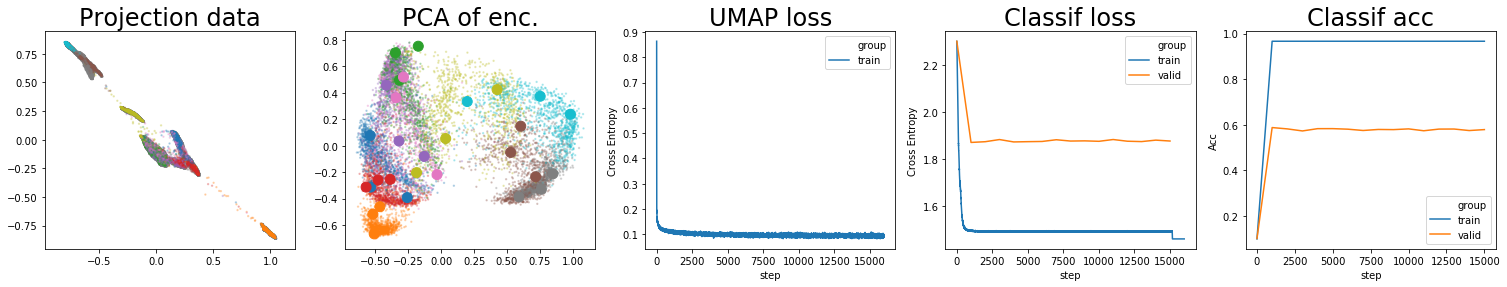

batch: 17000


17000


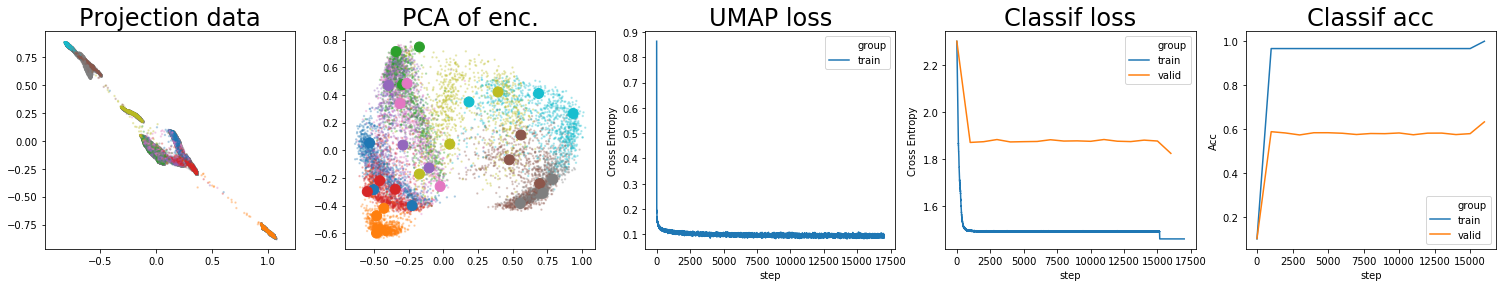

batch: 18000


18000


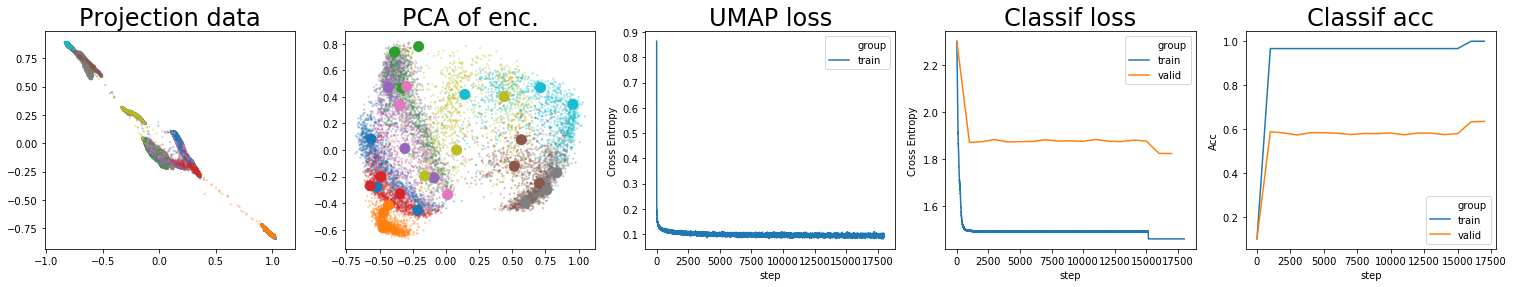

batch: 19000


19000


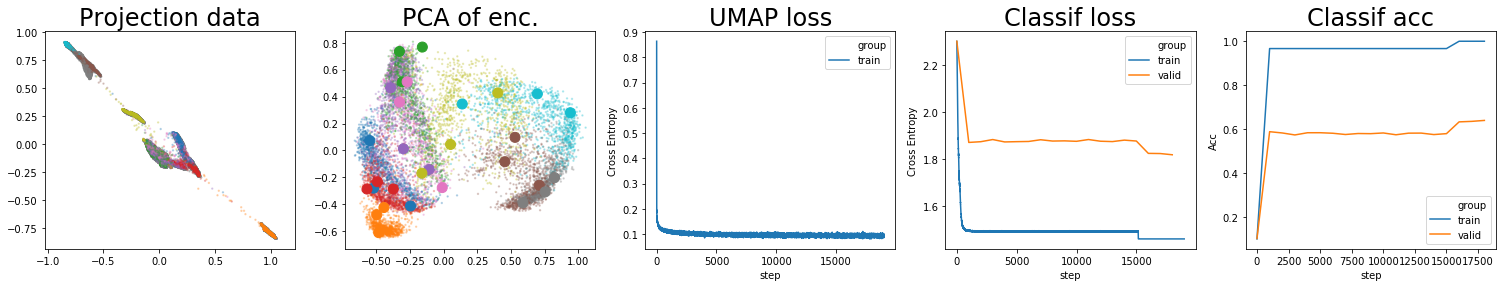

batch: 20000


20000


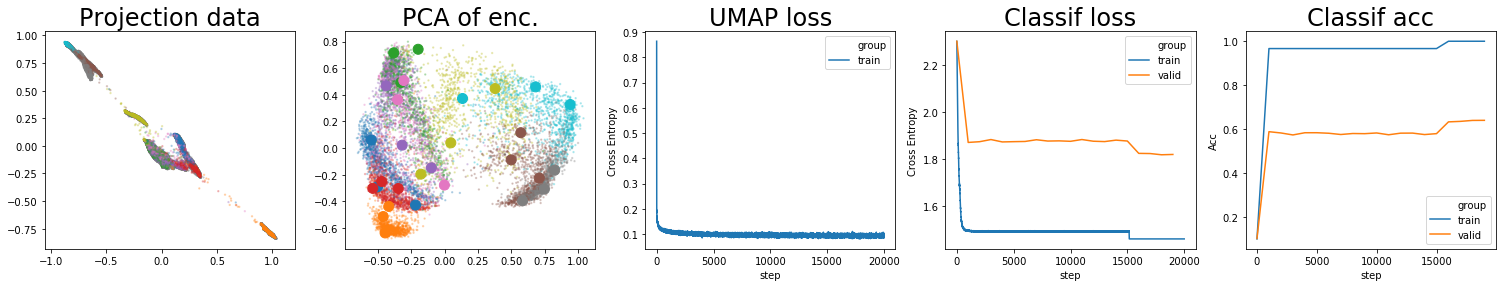

KeyboardInterrupt: 

In [36]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    
    # train
    for bi, ((batch_to, batch_from), (X, y)) in tqdm(
        enumerate(zip(edge_epoch, labeled_iter)), total=BATCHES_PER_EPOCH, leave=False
    ):
        if batch %1000 ==0:
            print("batch: {}".format(batch))
            plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')
            # validation loss
            classif_loss = model.get_dataset_loss(data_valid)
            model.write_losses(
                    batch=batch, classif_loss=classif_loss, umap_loss=None, train=False
                )
            model.write_acc(X_valid, Y_valid, batch, train=False)
            model.write_acc(X_labeled, Y_labeled, batch, train=True)
            
        batch_to = X_train[batch_to]
        batch_from = X_train[batch_from]
        # train model
        losses = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)
        model.write_losses(
            batch=batch, classif_loss=losses[3], umap_loss=losses[2], train=True
        )
        
        batch += 1


In [37]:
classif_loss = model.get_dataset_loss(data_valid)
tf.reduce_mean(classif_loss).numpy()

1.8212181

In [38]:
predictions = model.classify_data(X_labeled)
tf.keras.metrics.Accuracy()(predictions, Y_labeled).numpy()

1.0

In [39]:
predictions = model.classify_data(X_valid)
tf.keras.metrics.Accuracy()(predictions, Y_valid).numpy()

0.6375

In [40]:
predictions = model.classify_data(X_test)
tf.keras.metrics.Accuracy()(predictions, Y_test).numpy()

0.6349

In [41]:
predictions

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([5, 2, 1, ..., 8, 1, 5])>

In [ ]:
tf.argmax(model.classifier(model.encoder(X_train[:100])), axis=1)

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

In [ ]:
loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

In [ ]:
loss_df.variable.unique()

In [ ]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

In [ ]:
sns.lineplot(
    x="step",
    y="val",
    hue="group",
    data=loss_df[loss_df.variable == "umap_loss"],
    ci=None,
)

In [ ]:
sns.lineplot(
    x="step",
    y="val",
    hue="group",
    data=loss_df[loss_df.variable == "acc_classif"],
    ci=None,
)